In [1]:
from google.colab import drive
import os
drive.mount('/content/drive/')
os.chdir("drive/My Drive/Google_Colab_Drive/DCGAN_Projects_TF2.X/Generate_Synthetic_Images_wDCGANs")
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/
dcgan_demo.gif				     image_at_epoch_0002.png
DCGAN.png				     plot_utils.py
Generate_Synthetic_Images_with_DCGANs.ipynb  __pycache__
image_at_epoch_0001.png


## Task 1: Project Overview and Import Libraries

In [2]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import plot_utils
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.3.0


## Task 2: Load and Preprocess the Data

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype(np.float32)/255.0
x_test = x_test.astype(np.float32)/255.0
print (x_train.shape, y_train.shape, x_test.shape, y_test.shape)

4423680/4422102 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


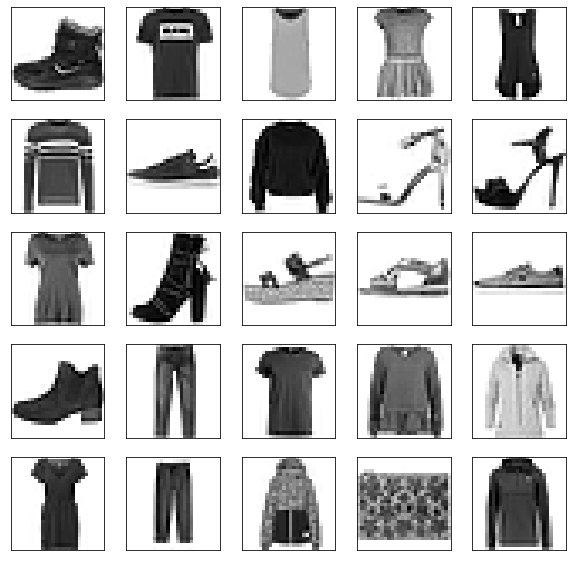

In [4]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
plt.show()


## Task 3: Create Batches of Training Data

In [5]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset = dataset.batch(batch_size=batch_size, drop_remainder=True).prefetch(1)

## Task 4: Build the Generator Network for DCGAN

![GAN](DCGAN.png)

**Generator** is an upsampling network with fractionally-strided convolutions

**Discriminator** is a convolutional network

We are going perform Gradient Ascent on Discriminator and Generator. The objective function for Generator is to maximize the likelihood of the Discriminator being wrong.

Architecture guidelines for stable Deep Convolutional GANs:

- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers expect for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers.

[Source](https://arxiv.org/pdf/1511.06434.pdf): Radford et al, "*Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks*", ICLR 2016

In [11]:
num_features = 100 

generator_model = tf.keras.Sequential([
    # Change it to 7*7*256 if you have a GPU otherwise 7*7*128
    keras.layers.Dense(7*7*256, input_shape=[num_features, ]), # Takes Random noise with predetermined seed as input
    keras.layers.Reshape([7,7,256]), # [7,7,256] if on GPU otherwise [7,7,128]
#     if on GPU
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(128, (5,5), (2,2), padding='same', activation='selu'),
#     if on GPU end
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, (5,5), (2,2), padding='same', activation='selu'),
    keras.layers.BatchNormalization(),
    # if on cpu
    # keras.layers.Conv2DTranspose(1, (5,5), (2,2), padding='same', activation='tanh')
    # if on cpu end
 #     if on GPU   
    keras.layers.Conv2DTranspose(1, (5,5), (1,1), padding='same', activation='tanh')
 #     if on GPU  end
])


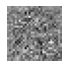

In [12]:
noise = tf.random.normal(shape=[1, num_features])
generated_image = generator_model(noise, training = False)
plot_utils.show(generated_image, 1)

In [13]:
generator_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 7, 7, 256)         1024      
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 128)       819328    
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 28, 28, 64)        204864    
_________________________________________________________________
batch_normalization_5 (Batch (None, 28, 28, 64)       

## Task 5: Build the Discriminator Network for DCGAN

In [14]:
discriminator_model = keras.models.Sequential([
    keras.layers.Conv2D(64, (5,5), (2,2), padding='same', input_shape = [28,28,1]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, (5,5), (2,2), padding='same'),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
#     if on GPU
    keras.layers.Conv2D(256, (5,5), (1,1), padding='same'),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
#     if on GPU end
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])
discriminator_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 256)        

In [15]:
decision = discriminator_model(generated_image)
decision.numpy()

array([[0.49969143]], dtype=float32)

## Task 6: Compile the Deep Convolutional Generative Adversarial Network (DCGAN)

In [16]:
discriminator_model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop')
discriminator_model.trainable = False # we only want to be able to train generator_model for the combined model.
dcgan = keras.models.Sequential([generator_model, discriminator_model])
dcgan.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop')

## Task 7: Define Training Procedure

In [17]:
seed = tf.random.normal(shape=[batch_size, 100])

In [18]:
## Source https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10,10))
    
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [19]:
def train_dcgan(gan, dataset, batch_size, num_features, epochs = 5):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(epochs)):
        print("Epochs: {}/{}".format(epoch+1, epochs))
        for X_batch in dataset:
            noise = tf.random.normal(shape=[batch_size, num_features])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis = 0)
            # Real image == 1, fake image == 1
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        display.clear_output(wait = True)
        generate_and_save_images(generator, epoch+1, seed)
    display.clear_output(wait = True)
    generate_and_save_images(generator, epochs, seed)

## Task 8: Train DCGAN

In [20]:
x_train_dcgan = np.expand_dims(x_train, axis = -1 )
x_train_dcgan.shape

(60000, 28, 28, 1)

In [21]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)

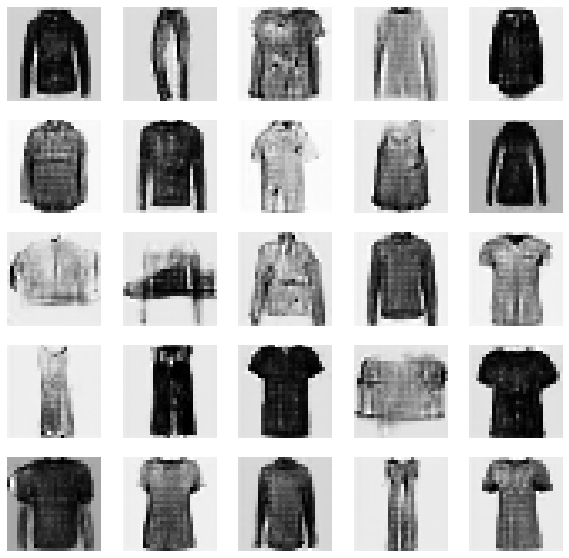

CPU times: user 59min 12s, sys: 4min 2s, total: 1h 3min 15s
Wall time: 1h 32min 45s


In [22]:
%%time
train_dcgan(gan=dcgan, dataset=dataset, batch_size=batch_size, num_features=num_features, epochs=100)

## Task 9: Generate Synthetic Images with DCGAN

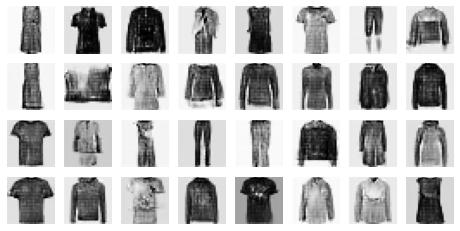

In [23]:
noise = tf.random.normal(shape=[batch_size, num_features])
generated_image = generator_model(noise)
plot_utils.show(generated_image, 8) 

In [3]:
## Source: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif

import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


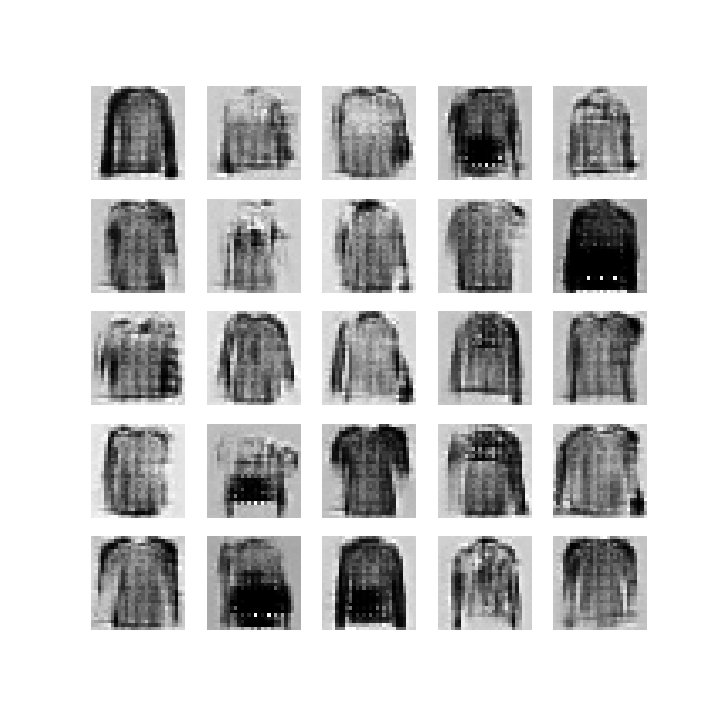

In [4]:
import IPython
IPython.display.Image(filename=anim_file)